In [1]:
import pandas as pd
import csv
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from descartes import PolygonPatch

from matplotlib import pyplot as plt
import geojson
from shapely.geometry import Point, mapping, shape
from fiona import collection
import fiona
import geopandas as gpd
import geoplot 

In [2]:
rasterio.gdal_version()

'3.0.4'

## Setting up the data files

In [3]:
# getting the path of the current jupyter notebook
Path.cwd()

WindowsPath('G:/Omdena/wfpdisrel/#task1-datacollection/#task1-datacollection-climada/notebooks')

In [4]:
# reading in the Gridded Population of the World dataset
data_folder = Path.cwd().parent.parent.joinpath('datasets', 'Gridded Population of the World (GPW)')
#print(data_folder)
input_filename = 'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif'
input_raster_file = Path(data_folder).joinpath(input_filename)
print(input_raster_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif


In [5]:
# reading in the shapefile
shape_data_folder = Path.cwd().parent.joinpath('data', 'Texas')
print(shape_data_folder)
shape_filename = 'Texas_State_Boundary_Detailed.shp' 
input_shape_file = Path(shape_data_folder).joinpath(shape_filename)

G:\Omdena\wfpdisrel\#task1-datacollection\#task1-datacollection-climada\data\Texas


### Checking the datasetss

In [6]:
raster_data = rasterio.open(input_raster_file)

In [7]:
raster_data.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -407649103380480.0,
 'width': 43200,
 'height': 17400,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00833333333333339, 0.0, -180.0,
        0.0, -0.00833333333333339, 85.0000000000092)}

In [8]:
#raster_data.closed

## Masking a raster using a shapefile

In [9]:
with fiona.open(input_shape_file, "r") as shapefile:    
    shapes = [feature["geometry"] for feature in shapefile]

In [10]:
shapefile.closed

True

In [11]:
# read geometries, and mask out regions of a raster that are outside the polygons defined in the shapefile
with rasterio.open(input_raster_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

In [12]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -407649103380480.0,
 'width': 43200,
 'height': 17400,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00833333333333339, 0.0, -180.0,
        0.0, -0.00833333333333339, 85.0000000000092)}

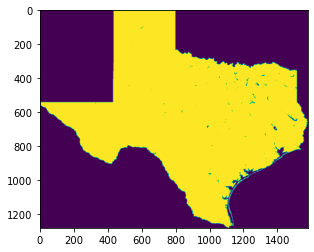

In [13]:
show(out_image)

In [14]:
rasterio.features.geometry_window(raster_data, shapes)

Window(col_off=8802, row_off=5819, width=1578, height=1281)

## Calculating effected population based on a shapefile

In [15]:
from rasterstats import zonal_stats

In [16]:
print(input_shape_file)

G:\Omdena\wfpdisrel\#task1-datacollection\#task1-datacollection-climada\data\Texas\Texas_State_Boundary_Detailed.shp


In [17]:
stats = ['sum']
#stats = ['min', 'max', 'mean', 'count', 
#              'sum', 'std', 'median', 'majority', 
#              'minority', 'unique', 'range']

In [18]:
with fiona.open(input_shape_file) as src:
    #print(src.crs)
    result = zonal_stats(src, input_raster_file, stats = stats)
print (result)

[{'sum': 27503420.0}]


In [19]:
population = result[0]['sum']
print ('Population of Texas is: ' + str(population))

Population of Texas is: 27503420.0


Ok... there are 27.50 million inhabitants in Texas (based on data from 2015). Google search prodvides a value 27.49 million. So that should be kind of accurate.

In [20]:
## TODO: add assertion that both files have the same CRS